# Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error

In [3]:
pd.options.display.max_columns = 50

In [4]:
plt.rcParams['font.size'] = 16

# Read data

In [5]:
with open('./midvalDataPath.txt', 'r') as fp:
    path_to_data = fp.read()

In [6]:
data = pd.read_csv(path_to_data)

In [ ]:
data.head()

In [ ]:
# from pprint import pprint
# pprint(data.columns.tolist())

## Cleaning up the junk

In [7]:
def checkColumn(df, colNum):
    """
    Used in throwAwayUnchanged
    """
    return np.all(df.iloc[0, colNum] == df.iloc[1:, colNum])


def throwAwayUnchanged(df):
    """
    Made specifically for the data we were given for the Midvale project. 
    Could, however, prove useful on subsetted-by-group data...
    This function throws away columns that are the same in every entry
    """
    idxUnhelpful = [j for j in range(df.columns.size)
                    if checkColumn(df, j)]
    df = df.drop(df.columns[idxUnhelpful], axis=1)
    return df


def throwAwayBizarre(df):
    """
    Throws away rows where TotalBytes is negative 
    (because this doesn't make sense).
    """
    df = df.loc[df['TotalBytes'] >= 0]
    return df


def removeUnwanted(data):
    """
    Made specifically for the data we were given for the Midvale project. 
    """
    # Don't worry about High Performance mode for this task
    data = data.groupby('Mode').get_group(0)
    # Flicker is not useful for prediction
    data = data.drop('Flicker', axis=1)
    # We will throw away columns that are all the same
    # (On `data`, this gets rid of Sharpening, 
    #  WaitSeconds and Status)
    data = throwAwayUnchanged(data)
    data = throwAwayBizarre(data)
    data = data.drop('Index', axis=1)
    return data


def fixMiscValues(df):
    """
    Made specifically for the data we were given for the Midvale project. 
    """
    df = df.fillna({'TertiaryResolution': 'NaN'})
    df = df.replace('-', value=0)
    df['SecondaryBitsPerSecond'] = df['SecondaryBitsPerSecond'].astype(np.float64)
    df['TertiaryBitsPerSecond'] = df['TertiaryBitsPerSecond'].astype(np.float64)
    return df


def preProcess(df):
    """
    Made specifically for the data we were given for the Midvale project
    """
    df = removeUnwanted(df)
    df = fixMiscValues(df)
    return df

In [8]:
data = preProcess(data)

# Make a subset of the data for a simpler time

First we have to figure out the subset...

Roger recommended sticking with `Test == Base` and a single camera. Let's choose the camera with the most observations.

In [9]:
Base_gb_CameraName = data.loc[data['Test']=='Base'].groupby(['CameraName'])
CameraName_highestCountOf_Base = Base_gb_CameraName.count()['Test'].argmax()
data_A3Base = Base_gb_CameraName.get_group(CameraName_highestCountOf_Base)
data_A3Base = data_A3Base.drop(['CameraName', 'Test'], axis=1)

In [ ]:
data_A3Base.head()

# Data exploration

## Histogram of continuous

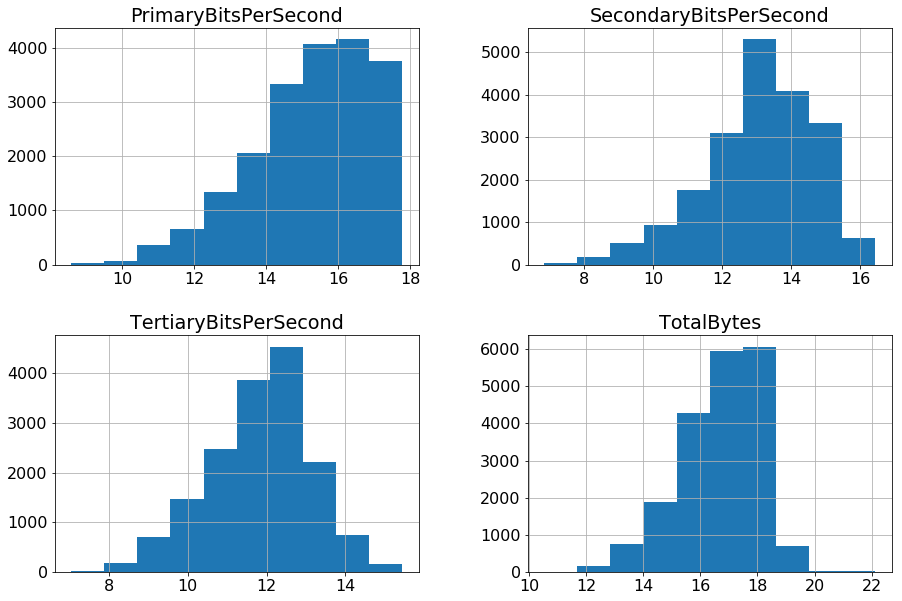

In [11]:
logBytes = data.loc[:, ['TotalBytes', 'PrimaryBitsPerSecond', 'SecondaryBitsPerSecond', 'TertiaryBitsPerSecond']]
logBytes = logBytes.replace(0., np.nan).apply(lambda x: np.log(x)).dropna(how='all')
logBytes.hist(figsize=(15,10));

In [12]:
def logTransformColumn(df, colname):
    """
    Tailor-made for the Midvale data. 
    log-transforms the columns pertaining to bit-rate.
    """
    logBytes = data[colname]
    logBytes = logBytes.replace(0., np.nan).apply(lambda x: np.log(x))
    logBytes = logBytes.dropna(how='all')
    return df.assign(**{'log'+logBytes.name: logBytes})

def logTransformBytes(df):
    for columnName in ['TotalBytes', 'PrimaryBitsPerSecond', 
                       'SecondaryBitsPerSecond', 'TertiaryBitsPerSecond']:
        df = logTransformColumn(df, columnName)
    return df

In [13]:
data = logTransformBytes(data)
data_A3Base = logTransformBytes(data_A3Base)

In [ ]:
data.head()

In [ ]:
data_A3Base.head()

## Histogram of categoricals

In [14]:
def hist_colVals(X, **kwargs):
    """
    X : a categorical column of a data frame
    """
    # Check if not categorical
    #
    #
    # get value counts
    vc = X.value_counts()
    n = vc.shape[0]
    xrange = np.arange(n)
    plt.bar(xrange, vc.values, **kwargs)
    plt.xticks(xrange, vc.index.tolist(), rotation=90)
    return
    
    

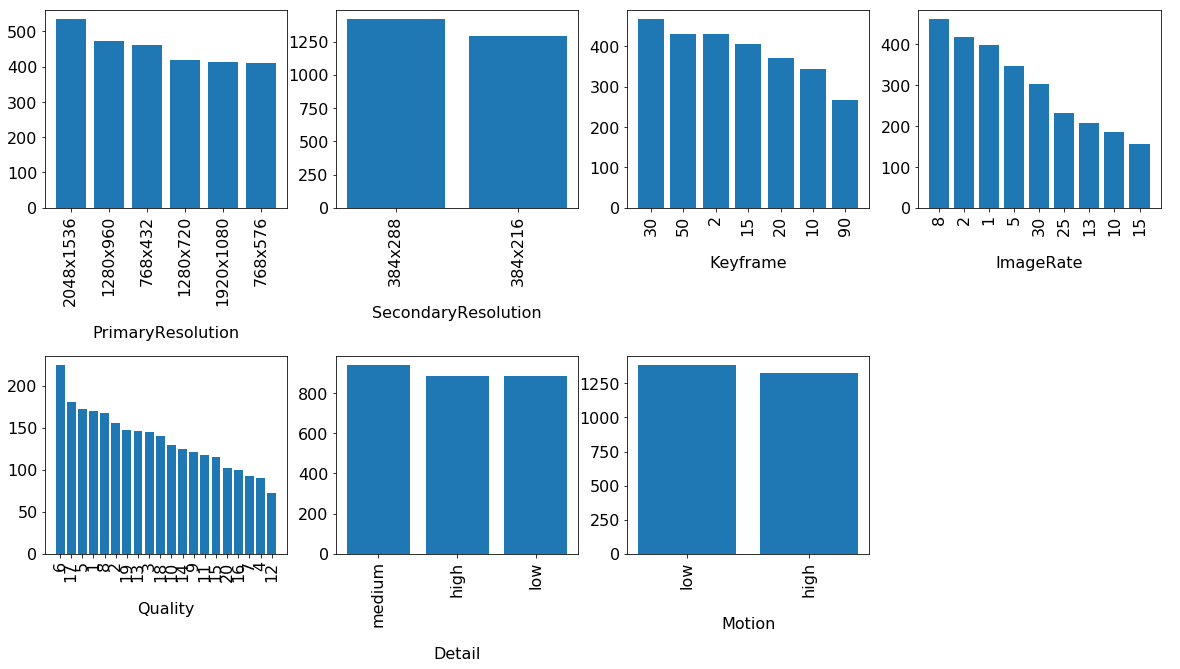

In [15]:
# make a histogram of these
# (these are the *useful* categories for CamerName:A3;Test:Base)
categs = ['PrimaryResolution', 'SecondaryResolution', 
          'Keyframe', 'ImageRate', 'Quality',
          'Detail', 'Motion']

C = len(categs)
ncols = 4
nrows = np.int(np.ceil(C/5))
figwidth = 20
figheight = np.int(np.min([np.ceil(20/ncols*nrows), 20]))

fig, axes = plt.subplots(nrows, ncols, figsize=(figwidth, figheight))
fig.subplots_adjust(hspace=.75)

for j, categ in enumerate(categs):
    plt.subplot(nrows, ncols, j+1)
    hist_colVals(data_A3Base[categ])
    plt.xlabel(categ, labelpad=20)
for j in range(C, nrows*ncols):
    plt.subplot(nrows, ncols, j+1)
    plt.axis('off')

## Finding correlations with PrimaryBitsPerSecond

In [16]:
from sklearn.preprocessing import StandardScaler

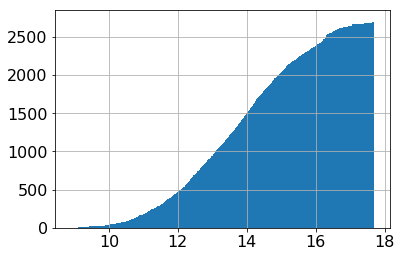

In [17]:
data_A3Base['logPrimaryBitsPerSecond'].hist(bins=1000, cumulative=True)

In [18]:
scaler = StandardScaler()
qualityResponse = scaler.fit_transform(data_A3Base.loc[:, ['Quality', 'logPrimaryBitsPerSecond']])

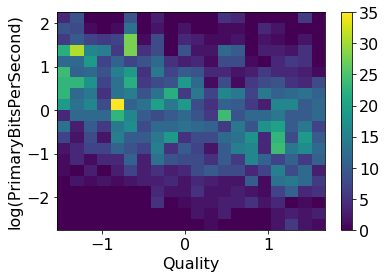

In [19]:
plt.hist2d(qualityResponse[:,0],
           qualityResponse[:,1],
           bins=20);
plt.xlabel('Quality')
plt.ylabel('log(PrimaryBitsPerSecond)')
plt.colorbar();

# A very simple linear regression

In [20]:
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data_A3Base.loc[:,['Quality', 'ImageRate', 'Keyframe']].values,
                                                    data_A3Base['logPrimaryBitsPerSecond'].values)

In [22]:
en = ElasticNetCV(normalize=True)
en.fit(X_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1, normalize=True,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [23]:
en.score(X_test, y_test)

0.48322579290589274

# Encoding features for regression

## Encoding the categoricals

If there are any categoricals, then maybe we should put columns as integers so we can regress on them? 

In [24]:
def categDF(data):
    categoricals = data.select_dtypes(include=['object'])
    categoricals = categoricals.drop('Message', axis=1)
    return categoricals


In [25]:
def setUpCategs(data, sparse=False):
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
    lb = LabelEncoder()
    oh = OneHotEncoder()
    categoricals = categDF(data)
    categoricals = categoricals.apply(lb.fit_transform)
    categoricals = oh.fit_transform(categoricals)
    if not sparse:
        categoricals = categoricals.toarray()
    return categoricals


In [26]:
def unencodeOneHotLabelling(ohEnc, oh, lbl):
    return lbl.inverse_transform(oh.active_features_)[np.argmax(ohEnc, axis=-1)]

In [27]:
categoricals = setUpCategs(data)

In [28]:
categoricals_A3Base = setUpCategs(data_A3Base)

In [29]:
categ_df = categDF(data)

In [30]:
categ_df_A3Base = categDF(data_A3Base)

In [ ]:
categ_df_A3Base.head()

### Can we unscramble categoricals?

In [31]:
elems = pd.DataFrame(np.array([['cat', 'dog', 'mouse', 'mouse', 'cat', 'guineapig'],['white', 'white', 'white', 'red', 'black', 'orange']]).T, columns=['animal', 'colour'])
elems

,animal,colour
0,cat,white
1,dog,white
2,mouse,white
3,mouse,red
4,cat,black
5,guineapig,orange


In [32]:
lblDemo = LabelEncoder()
ohDemo = OneHotEncoder()

In [33]:
lblDemo.fit_transform(elems.values.ravel())

array([1, 7, 2, 7, 4, 7, 4, 6, 1, 0, 3, 5])

In [34]:
lblDemo.inverse_transform([1,2,3])

array(['cat', 'dog', 'guineapig'], dtype=object)

In [35]:
ohEncodingOfAnimals = ohDemo.fit_transform(np.c_[lblDemo.fit_transform(elems.values.ravel())]).toarray()

In [36]:
lblDemo.inverse_transform(ohDemo.active_features_)[np.argmax(ohEncodingOfAnimals, axis=-1)]

array(['cat', 'white', 'dog', 'white', 'mouse', 'white', 'mouse', 'red',
       'cat', 'black', 'guineapig', 'orange'], dtype=object)

## Now for the continous

In [37]:
numerical_names = ['Keyframe', 'ImageRate', 'Quality', 'KbpsLimit', 'CollectSeconds']
numerical = data.filter(items=numerical_names)
numerical_A3Base = data_A3Base.filter(items=numerical_names)

In [ ]:
numerical.values[:5,:]

In [ ]:
numerical_A3Base.values[:5,:]

## Now the response(s)
TotalBytes should never be negative so far as I'm aware, so let's fix this:

In [38]:
response_names = ['logTotalBytes', 'logPrimaryBitsPerSecond', 'logSecondaryBitsPerSecond', 'logTertiaryBitsPerSecond']
responses = data.filter(items=response_names)
responses_A3Base = data_A3Base.filter(items=response_names)

In [ ]:
responses.values[:5,:]

In [ ]:
responses_A3Base.values[:5,:]

## How to unmuddle...

In [39]:
def getCategNames(df):
    return np.concatenate([np.unique(df[col].values) for col in df.columns])

In [40]:
def unencodeOneHot(ohArr, df):
    categNames = getCategNames(df)
    return [categNames[np.where(ohArr)[1]][j::2] for j in range(2)]

In [41]:
categNames_A3Base = getCategNames(categ_df_A3Base)

In [42]:
names_A3Base = np.concatenate((numerical_names, categNames_A3Base))

# Building regressors on the data

## Prepare the data

First on a small problem, then on a progressively bigger ones

In [43]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler

In [44]:
scaler = StandardScaler()

##### Making Covariates and Responses

In [45]:
X_full = np.hstack((scaler.fit_transform(numerical.values), categoricals))
y_full = responses.values
y_full_pbps = y_full[:,1]

/Users/aberk/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [46]:
X_A3Base = np.hstack((scaler.fit_transform(numerical_A3Base.values), categoricals_A3Base))
y_A3Base = responses_A3Base.values
y_A3Base_pbps = y_A3Base[:, 1]

/Users/aberk/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


##### Removing nan values?

In [47]:
nonnanrows_full = [not np.isnan(y_full_pbps[j]) for j in range(y_full_pbps.shape[0])]

X_full_nonnan = X_full[nonnanrows_full, :]
y_full_nonnan = y_full_pbps[nonnanrows_full]

In [48]:
nonnanrows = [not np.isnan(y_A3Base_pbps[j]) for j in range(y_A3Base_pbps.shape[0])]

X_nonnan = X_A3Base[nonnanrows, :]
y_nonnan = y_A3Base_pbps[nonnanrows]

In [49]:
print('There were no nan values to remove: {}'.format(X_full.shape == X_full_nonnan.shape))
print('Number of training examples is {}.'.format(X_full_nonnan.shape))

There were no nan values to remove: False
Number of training examples is (19855, 59).


In [50]:
print('There were no nan values to remove: {}'.format(X_A3Base.shape == X_nonnan.shape))
print('Number of training examples is {}.'.format(X_nonnan.shape))

There were no nan values to remove: True
Number of training examples is (2711, 20).


##### Train Test Split

In [51]:
print('Splitting full vanilla data into train and test...', end='')
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_full_nonnan, y_full_nonnan)
print('done.')

Splitting full vanilla data into train and test...done.


In [52]:
print('Splitting vanilla data into train and test...', end='')
X_train, X_test, y_train, y_test = train_test_split(X_nonnan, y_nonnan)
print('done.')

Splitting vanilla data into train and test...done.


##### Polynomial features

In [53]:
print('Generating interaction features of degree ≤ 2...', end='')
poly = PolynomialFeatures(degree=2, interaction_only=True)
polyf = PolynomialFeatures(degree=2, interaction_only=True)
X_nonnan_poly2 = poly.fit_transform(X_nonnan)
Xfn_poly2 = polyf.fit_transform(X_full_nonnan)
print('done.')

print('Size of A3Base poly features is {}.'.format(X_nonnan_poly2.shape))
print('Size of full poly features is {}.'.format(Xfn_poly2.shape))

print('Splitting poly2 data into train and test...', end='')
Xp2_train, Xp2_test, yp2_train, yp2_test = train_test_split(X_nonnan_poly2, y_nonnan)
Xfp2_train, Xfp2_test, yfp2_train, yfp2_test = train_test_split(Xfn_poly2, y_full_nonnan)
print('done.')

Generating interaction features of degree ≤ 2...done.
Size of A3Base poly features is (2711, 211).
Size of full poly features is (19855, 1771).
Splitting poly2 data into train and test...done.


## ElasticNet

In [54]:
en = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], n_jobs=-1)

### Fitting on data with no interaction terms

In [55]:
en.fit(X_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
       n_alphas=100, n_jobs=-1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

In [56]:
Rsq_vanilla_EN = en.score(X_test, y_test)
print('R^2 = {}'.format(Rsq_vanilla_EN))

R^2 = 0.889368122801296


In [57]:
MSE_vanilla_EN = mean_squared_error(y_test, en.predict(X_test))
print('MSE = {}'.format(MSE_vanilla_EN))

MSE = 0.3405153293879938


### Fitting on data with interaction terms

(**Note:** we do negligibly better with poly-degree=3)

In [58]:
en.fit(Xp2_train, yp2_train)

/Users/aberk/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
       n_alphas=100, n_jobs=-1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

In [59]:
Rsq_poly2_EN = en.score(Xp2_test, yp2_test)
print('R^2 = {}'.format(Rsq_poly2_EN))

R^2 = 0.9298634386110338


In [60]:
MSE_poly2_EN = mean_squared_error(yp2_test, en.predict(Xp2_test))
print('MSE = {}'.format(MSE_poly2_EN))

MSE = 0.22480050308605712


Nice! I'm getting an R^2 value of .932, which means I'm explaining about 93 % of the variance for the A3 Camera in the Base Test.

### Notes

* We really want to predict `log(PrimaryBitsPerSecond)`. And we probably want to scale it first — Yes! Scaling the numerical sends the $R^2$ from .72 to .93!
* What are the other variables we want to scale? (See above...)
* Are we allowed to use Quality in our prediction? Yes! 

## Random forest regressors

In [61]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor

In [62]:
xTree = ExtraTreesRegressor(n_jobs=-1)
rf = RandomForestRegressor(n_jobs=-1)
gb = GradientBoostingRegressor()

### Fitting RF on vanilla data

In [63]:
gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [64]:
gb.score(X_test, y_test)

0.98471306918555757

In [65]:
mean_squared_error(y_test, gb.predict(X_test))

0.047051848105785624

This isn't fair...

#### Visualizing important features

In [66]:
idx_importance = np.argsort(gb.feature_importances_)[::-1]

print(np.column_stack((names_A3Base, gb.feature_importances_))[idx_importance, :])

[['ImageRate' 0.1875158867429818]
 ['Quality' 0.1511907701971947]
 ['Keyframe' 0.13704966090840615]
 ['CollectSeconds' 0.08165236618421329]
 ['low' 0.07656360892746206]
 ['2048x1536' 0.06544005952895092]
 ['768x432' 0.06435143465941774]
 ['1920x1080' 0.06330958151661266]
 ['768x576' 0.06255643273093771]
 ['high' 0.045744525589884]
 ['low' 0.02445032090133445]
 ['high' 0.020394341484404888]
 ['1280x960' 0.012299542270778547]
 ['1280x720' 0.007481468357421095]
 ['384x288' 0.0]
 ['384x216' 0.0]
 ['NaN' 0.0]
 ['Off' 0.0]
 ['KbpsLimit' 0.0]
 ['medium' 0.0]]


### Fitting RFs on data with degree 2 interactions

In [67]:
gb.fit(Xp2_train, yp2_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [68]:
gb.score(Xp2_test, yp2_test)

0.98391166791454709

In [69]:
mean_squared_error(yp2_test, gb.predict(Xp2_test))

0.051566045939548354

Super unfair...

#### Viewing important features

In [70]:
polyFeatureNames_A3Base = poly.get_feature_names(names_A3Base)

Print those features that were **above $1\sigma$ importance**.

In [71]:
idx_importance_sorted = gb.feature_importances_.argsort()[::-1]

In [72]:
th = gb.feature_importances_.mean() + gb.feature_importances_.std()
for j in idx_importance_sorted:
    coef = gb.feature_importances_[j]
    if coef < th:
        break
    else:
        ftrName = polyFeatureNames_A3Base[j]
        coef = gb.feature_importances_[j]
        print(ftrName, end='')
        print(' '*(30-len(ftrName)), end='')
        print(coef)

ImageRate                     0.045772194412
Quality NaN                   0.0394980312404
ImageRate CollectSeconds      0.0391174161703
Keyframe CollectSeconds       0.0375500294879
Keyframe Off                  0.0341215357276
ImageRate low                 0.0318074683224
ImageRate NaN                 0.0287853420985
Keyframe low                  0.028398654279
Quality Off                   0.0278292824982
Quality                       0.0270897019144
low                           0.0253269250746
Quality CollectSeconds        0.0235956556616
Keyframe ImageRate            0.0230087754445
1920x1080 NaN                 0.0200962455656
ImageRate Off                 0.0198177464728
768x576 NaN                   0.0194536776599
CollectSeconds high           0.0181182628741
2048x1536 NaN                 0.0175035723368
Keyframe 1280x960             0.0167390715394
CollectSeconds NaN            0.0154485448602
Keyframe NaN                  0.0147333301171
CollectSeconds Off            0.0146

## Using the full data? 

In [73]:
gbFull = GradientBoostingRegressor()
gbFull.fit(Xf_train, yf_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [74]:
gbFull.score(Xf_test, yf_test)

0.94268334142715804

On the full data, we still get an R^2 coefficient of ~94%!